In [79]:
#Author: Eren Ali Aslangiray

import librosa
from librosa import display
import time
import os
import pandas as pd
import joblib
import numpy as np

sr=22050

### Author's Notes:

At part 1, I tried to build various models and with using different feature extraction methods to find best data extraction and model to use it on mass model building step. So part 1 is mini version and the exeperimental area of the whole work.

# ----------------------DATA PREPARING----------------------

# 1- RAVDESS DATABASE

## 1.1- Data Extraction

In [24]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24'
lst = []

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file) == "/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/.DS_Store":
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = int(file[7:8]) - 1
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [26]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [33]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 1.2- Data Load

In [115]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/y.joblib')

## 1.3- MEAN MFCCs KERAS MODEL (With 8 Emotion Label)

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

Using TensorFlow backend.


In [80]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
__________

In [82]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model.h5')
loaded_model.summary()
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

## 1.4- MEAN MFCCs KERAS MODEL (With reduced labels. Labels = 4)

In [116]:
#Dont forget to load data from 1.2
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
# 0 = neutral, 1 = angry, 2 = happy, 3 = sad
#calm became neutral. fearful, disgust, surprised will be removed. 
i = 0
for item in y:
    if item == 1:
        y[i]=0
    i = i+1
i = 0
for item in y:
    if item==4:
        y[i]=1
    i = i +1

lista = list(X)
listb = list(y)
dellist = [5,6,7]

for i in range (len(listb)-1,-1,-1):
    if listb[i] in dellist:
        lista.pop(i)
        listb.pop(i)

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(lista), np.asarray(listb), test_size=0.33, random_state=42)

In [118]:
#DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

In [119]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       378
           1       0.91      0.87      0.89       238
           2       0.85      0.81      0.83       267
           3       0.75      0.82      0.79       243

   micro avg       0.84      0.84      0.84      1126
   macro avg       0.84      0.84      0.84      1126
weighted avg       0.84      0.84      0.84      1126



In [67]:
#Now its time for keras :)

import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

Using TensorFlow backend.


In [68]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [69]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

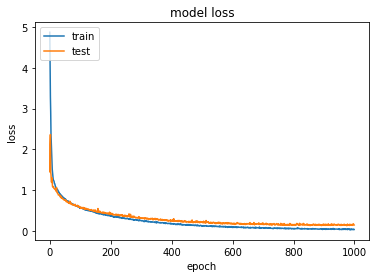

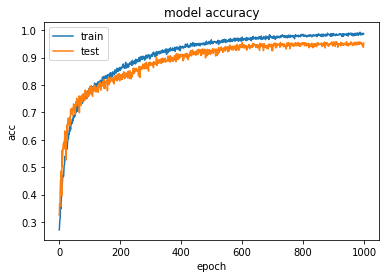

In [71]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       378
           1       0.96      0.92      0.94       238
           2       0.95      0.94      0.94       267
           3       0.94      0.96      0.95       243

   micro avg       0.95      0.95      0.95      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.95      0.95      0.95      1126



In [74]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)
# 0 = neutral, 1 = angry, 2 = happy, 3 = sad

[[371   0   3   4]
 [  5 219  10   4]
 [  4   7 250   6]
 [  8   2   0 233]]


In [75]:
model_name = 'Emotion_Voice_Detection_Model_Reduced_Labels.h5'
save_dir = '/Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/erenmac/Desktop/ENGR498/Code/Voice_Emo_Rec_Models/Emotion_Voice_Detection_Model_Reduced_Labels.h5 


In [78]:
loaded_model = keras.models.load_model('Emotion_Voice_Detection_Model_Reduced_Labels.h5')
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1126/1126 [==============================] - 0s 173us/step
Restored model, accuracy: 95.29%


## 1.5- MEAN DB AMPLITUDE MODEL AND .T VERSION (Soruce Data - LESS Data)

In [101]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/X_wave.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/Audio_Speech_Actors_01-24/Joblib_saves/y_wave.joblib')

In [102]:
X_db = []
for item in X:
    S = librosa.feature.melspectrogram(y=item, sr=sr)
    k = np.mean(librosa.amplitude_to_db(S, ref=np.max).T,axis=0)
    X_db.append(k)
    
print (len(X_db))

1440


In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X_db), y, test_size=0.33, random_state=42)

In [92]:
#DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

In [93]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.29      0.34      0.31        32
           1       0.53      0.49      0.51        59
           2       0.24      0.21      0.22        67
           3       0.24      0.22      0.23        59
           4       0.25      0.22      0.23        68
           5       0.26      0.28      0.27        61
           6       0.30      0.33      0.31        64
           7       0.33      0.36      0.35        66

   micro avg       0.30      0.30      0.30       476
   macro avg       0.30      0.31      0.30       476
weighted avg       0.30      0.30      0.30       476



# 2- SAVEE DATABASE

## 2.1- Data Extraction

In [14]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/1'
lst = []
numlist = ["0","1","2","3","4","5","6","7","8","9"]

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = file[0:2]
        if file[1] in numlist:
            file = file[0]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [16]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [24]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"a":4,"d":6,"f":5,"h":2 ,"n":0 ,"sa":3 ,"su":7}
newy = []
for item in y:
    newy.append(label_to_num[item])
y = newy

In [26]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 2.2- Data Load

In [29]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/AudioData/Joblib/y.joblib')
y = np.asarray(y)

# 3- GERMAN DATABASE

## 3.1- Data Extraction

In [34]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/wav'
lst = []

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        file = file[5]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [36]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [39]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"W":4,"L":1,"E":6,"A":5 ,"F":2 ,"T":3,"N":0}
newy = []
for item in y:
    newy.append(label_to_num[item])
y = newy

In [41]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 3.2- Data Load

In [42]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/German_DB/Joblib/y.joblib')
y = np.asarray(y)

# 4- TESS DATABASE

## 4.1- Data Extraction

### 4.1.1- Web Crawling (Database items are available at different links)

In [3]:
import os, ssl
from bs4 import BeautifulSoup
import urllib.request
import re
import shutil
import requests
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
starturl = "https://tspace.library.utoronto.ca/handle/1807/24501"
initbaseurl = "https://tspace.library.utoronto.ca/handle/1807/"
baseurl = "https://tspace.library.utoronto.ca"
urllist = []
x = int(starturl[-5:])
while x > 24487:
    urllist.append(initbaseurl + str(x))
    x = x-1

In [5]:
data_urls = []

for item in urllist:
    r = requests.get(item)
    data = r.text
    soup = BeautifulSoup(data)
    for link in soup.find_all('a'):
        if link.get('href').endswith(".wav"):
            data_urls.append(link.get('href'))

In [10]:
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"ps":7,"angry":4,"fear":5,"neurtal":0 ,"happy":2 ,"disgust":6 ,"sad":3}
labellist = ["ps.wav","angry.wav","fear.wav","neutral.wav","happy.wav","disgust.wav","sad.wav"]

In [ ]:
output_file_path = "/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/"
i = 0
for data in data_urls:
    for item in labellist:
        if item in data:
            url = baseurl + data
            output_file = output_file_path+str(i)+"_"+ item
            with urllib.request.urlopen(url) as response, open(output_file, 'wb') as out_file:
                shutil.copyfileobj(response, out_file)
            i = i+1

### 4.1.2- Data Extraction & Saving

In [30]:
path = '/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database'
lst = []
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
label_to_num = {"ps":7,"angry":4,"fear":5,"neutral":0 ,"happy":2 ,"disgust":6 ,"sad":3}

for subdir, dirs, files in os.walk(path):
    for file in files:
        if os.path.join(subdir,file).endswith('.DS_Store'):
            continue
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        for item in label_to_num:
            if item in str(file):
                file = label_to_num[item]
        arr = X, file
        lst.append(arr)
        if sample_rate != 22050:
            print (sample_rate)

In [32]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

In [36]:
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

## 4.2- Data Load

In [42]:
X = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib/X.joblib')
y = joblib.load('/Users/erenmac/Desktop/NEW_DATA_VOICE/TESS_Database/Joblib/y.joblib')
y = np.asarray(y)

# ----------------------MASS MODEL BUILDING----------------------

# 1- Data Preparing

### 1.1- Gathering All The Datasets Together

In [50]:
#bla bla bla

### 1.2- Saving The Big Dataset

In [51]:
#bla bla bla

### 1.3- Feature Extraction

In [52]:
#bla bla bla

# 2- Model Building

### 2.1- MEAN MFCCs KERAS MODEL (/W using RAVDESS big data and other databases.)

In [54]:
#bla bla bla

### 2.2- MEAN MFCCs REDUCED KERAS MODEL (/W using RAVDESS big data and other databases.) (4 LABEL)

In [55]:
#bla bla bla

### 2.3- MEAN DB AMPLITUDE MODEL AND .T VERSION (/W using RAVDESS small data and other databases)

In [56]:
#bla bla bla

### 2.4- WAVELET DATA EXPLORATION & MODEL BUILDING

In [57]:
#bla bla bla

### 2.5- SAVING MODELS

In [58]:
#bla bla bla

# 3- Model Testing & Evaluating 

In [59]:
#bla bla bla